In [1]:
# # Import necessary libraries
# import scanpy as sc
# import numpy as np
# import pandas as pd
# import scipy.sparse as sp
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score, normalized_mutual_info_score, adjusted_rand_score
# from matplotlib.backends.backend_pdf import PdfPages
# import ot
# import decoupler as dc
# from sklearn.preprocessing import StandardScaler
# import seaborn as sns
# import spatialdata
# import warnings
# import stlearn as st
# import spatialdata_xenium_explorer

# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import MinMaxScaler
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.cluster import DBSCAN
# import matplotlib.pyplot as plt
# import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import time
import sys
import warnings
import os
import stlearn as st
import spatialdata_xenium_explorer

warnings.filterwarnings("ignore")
np.random.seed(42) 

/home/lemsaraa/miniconda3/envs/env1/lib/python3.10/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [3]:
out_folder= 'tab_out3'

In [4]:
# from pyscenic.aucell import aucell
# from pyscenic.genesig import GeneSignature

# def DS_calc_func(exprMatrices,DSignature, geneIDname="gene_symbol", useOrder="mean_rank",
#                  ntop=42, ceilThrsh=0.05, progStat=False, wghtd=True):
    

#     # Step 1: Order DSignature according to useOrder
#     DSignature = DSignature.sort_values(by=useOrder)
#     # Ensure ntop does not exceed available rows
#     ntop = min(ntop, DSignature.shape[0])

#     # Select top genes and split into UP and DOWN regulated groups
#     top_genes = DSignature.iloc[:ntop]
    
#     genesUP = top_genes.loc[top_genes['direction_foldchange'] == 1, geneIDname].values
#     genesDOWN = top_genes.loc[top_genes['direction_foldchange'] == -1, geneIDname].values

#     # Create gene signatures
#     gene_signatures = [
#         GeneSignature(name="UP", gene2weight=list(genesUP)),
#         GeneSignature(name="DOWN", gene2weight=list(genesDOWN))
#     ]

#     # Step 3: Calculate AUC for UP and DOWN gene sets using pyscenic's aucell function
#     auc_UP_DOWN = aucell(exprMatrices, gene_signatures, auc_threshold=ceilThrsh)

#     # Extract the AUCs for UP and DOWN gene sets
#     auc_UP = auc_UP_DOWN["UP"] if "UP" in auc_UP_DOWN.columns else None
    
#     auc_DOWN = auc_UP_DOWN["DOWN"] if "DOWN" in auc_UP_DOWN.columns else None

#     # Step 4: Calculate the damage score
#     if auc_UP is not None and auc_DOWN is not None:
#         Dscore = auc_UP * (sum(gene in exprMatrices.columns for gene in genesUP) / ntop) - \
#                  auc_DOWN * (sum(gene in exprMatrices.columns for gene in genesDOWN) / ntop)
#     else:
#         Dscore = auc_UP if auc_UP is not None else -auc_DOWN

#     return Dscore

In [5]:
def apply_dbscan_and_filter(df, k,feature, eps=0.004, min_samples=10, cluster_threshold=5):
    """
    Applies DBSCAN clustering on Podocyte microenvironments and filters valid clusters.

    Parameters:
        df (pd.DataFrame): DataFrame with Podocyte microenvironment data.
        k (int): Number of neighbors for Nphs2 aggregation.
        eps (float): DBSCAN epsilon value.
        min_samples (int): DBSCAN minimum samples value.
        cluster_threshold (int): Minimum Nphs2 sum to consider a cluster valid.

    Returns:
        pd.DataFrame: Filtered DataFrame with cluster assignments.
    """
    # Aggregate Nphs2 values for neighbors
    neighbors = NearestNeighbors(n_neighbors=k).fit(df[['imagecol', 'imagerow']])
    distances, indices = neighbors.kneighbors(df[['imagecol', 'imagerow']])
    df[feature+'_aggregated'] = [
        df.iloc[indices[i]][feature].sum() for i in range(len(indices))

    ]

    # Filter for glomeruli
    df_gloms = df[df[feature+'_aggregated'] > 0]

    # Apply DBSCAN clustering
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(df_gloms[['imagecol', 'imagerow']])
    db = DBSCAN(eps=eps, min_samples=min_samples)
    df_gloms['cluster'] = db.fit_predict(features_scaled)

    # Filter clusters by Nphs2 threshold
    cluster_sums = df_gloms.groupby('cluster')[feature].sum()
    valid_clusters = cluster_sums[cluster_sums > cluster_threshold].index
    filtered_df = df_gloms[df_gloms['cluster'].isin(valid_clusters)]

    return filtered_df

In [6]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import DataFrame, StrVector, FloatVector
from rpy2.robjects import pandas2ri

# Enable the conversion between pandas and R data frames
pandas2ri.activate()

# Import required R libraries
AUCell = importr("AUCell")
GSEABase = importr("GSEABase")

# Define the R function in Python
ro.r("""
DS_calc_func <- function(exprMatrices, DSignature, 
                         geneIDname = "gene_symbol", 
                         useOrder = c("mean_rank", "median_rank"),
                         ntop = 42, ceilThrsh = 0.05, progStat = FALSE, wghtd = TRUE) {
  require(AUCell)
  require(GSEABase)

  useOrder <- match.arg(useOrder)
  DSignature <- DSignature[order(DSignature[[useOrder]]),]

  genesUP <- DSignature[1:ntop, geneIDname][
    which(DSignature$direction_foldchange[1:ntop] == 1)]
  genesDOWN <- DSignature[1:ntop, geneIDname][
    which(DSignature$direction_foldchange[1:ntop] == -1)]

  geneSets <- GSEABase::GeneSetCollection(list(
    GeneSet(genesUP, setName = "UP"),
    GeneSet(genesDOWN, setName = "DOWN")
  ))

  exprMatrices <- as.matrix(exprMatrices)
  print(colnames(exprMatrices))
  cellRanks <- AUCell_buildRankings(exprMatrices, nCores = 1, plotStats = FALSE, verbose = progStat)
  print(cellRanks)
  cells_AUC <- AUCell_calcAUC(geneSets, cellRanks, verbose = progStat,
                              aucMaxRank = ceiling(ceilThrsh * nrow(cellRanks)))
  cells_AUC <- getAUC(cells_AUC)

  index1 <- 1
  index2 <- 2

  if (isTRUE(wghtd)) {
    coef1 <- sum(genesUP %in% rownames(exprMatrices)) / ntop
    coef2 <- sum(genesDOWN %in% rownames(exprMatrices)) / ntop
  } else coef1 <- coef2 <- 1

  if (nrow(cells_AUC) == 2) {
    Dscore <- cells_AUC[index1, ] * coef1 - cells_AUC[index2, ] * coef2
  } else if (rownames(cells_AUC) == "UP") {
    Dscore <- cells_AUC[index1, ]
  } else {
    Dscore <- -cells_AUC[index1, ]
  }

  return(Dscore)
}
""")

# Access the function in R
ds_calc_func = ro.globalenv['DS_calc_func']


In [9]:
# input data
dataset_paths = {
  '0027291__Region_1__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_2__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_3__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027291__Region_4__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",    
  '0027292__Region_1__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027292__Region_2__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027292__Region_3__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027292__Region_4__20240530__125814' : "/data/lemsaraa/amina/ST/ourData/20240530__124752__A4413_ST014_X0069_X0070/output-XETG00046__",
  '0027119__Region_1__20240621__120943': "/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__",
  '0027119__Region_2__20240621__120943': "/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__",
  '0027120__Region_1__20240621__120943':"/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__",
  '0027120__Region_2__20240621__120943': "/data/lemsaraa/amina/ST/ourData/20240621__120000__ST014_X0071_X0072_A4413/output-XETG00046__"
}

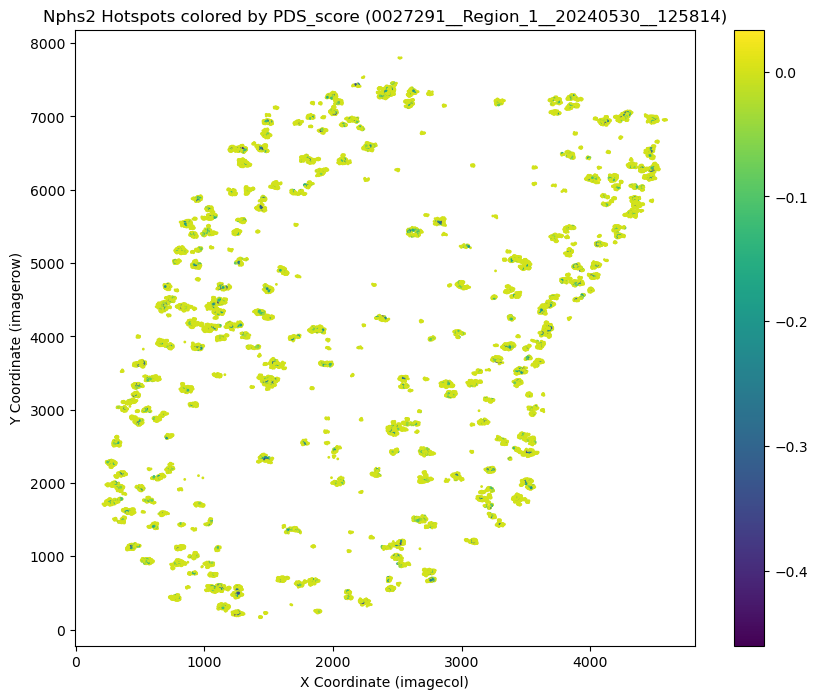

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


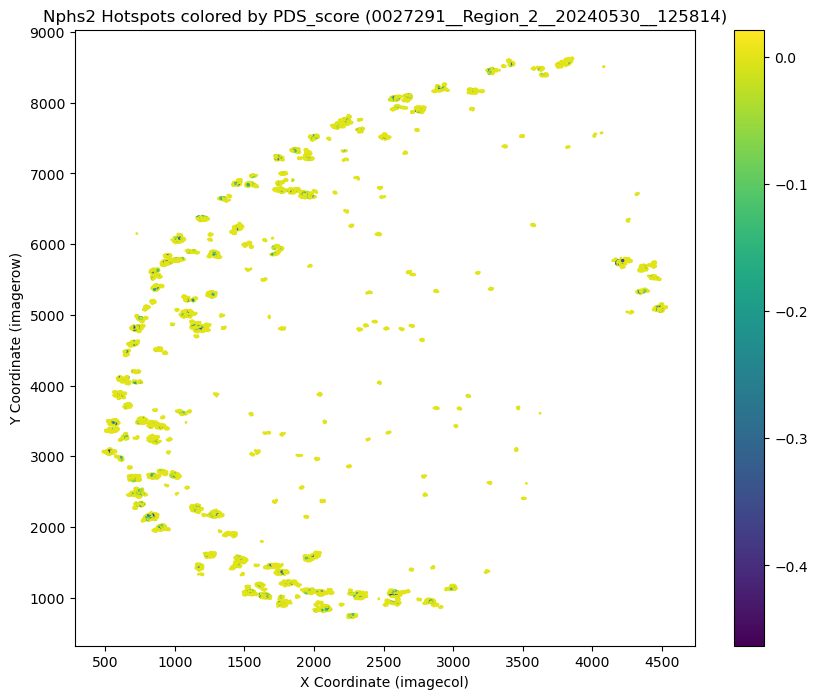

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


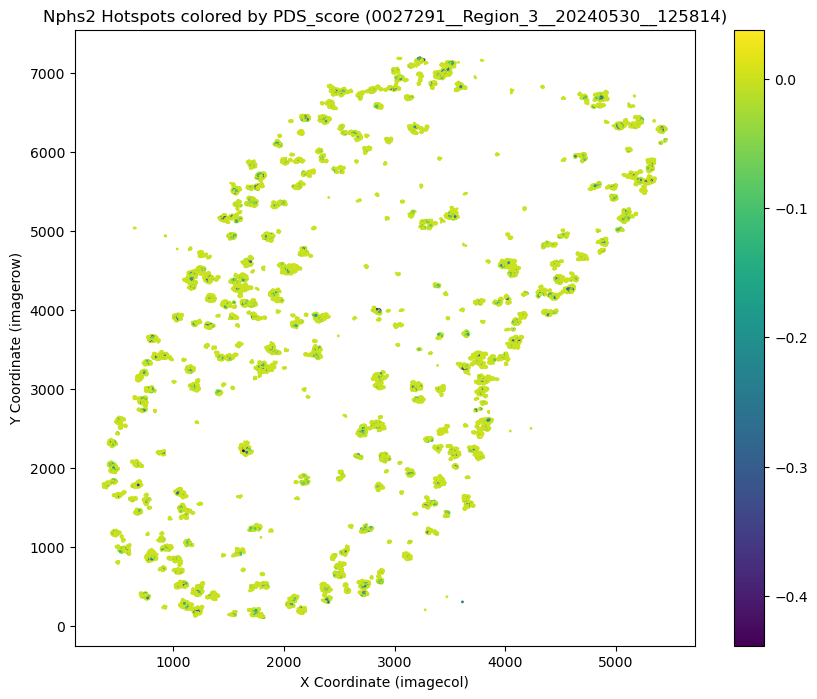

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


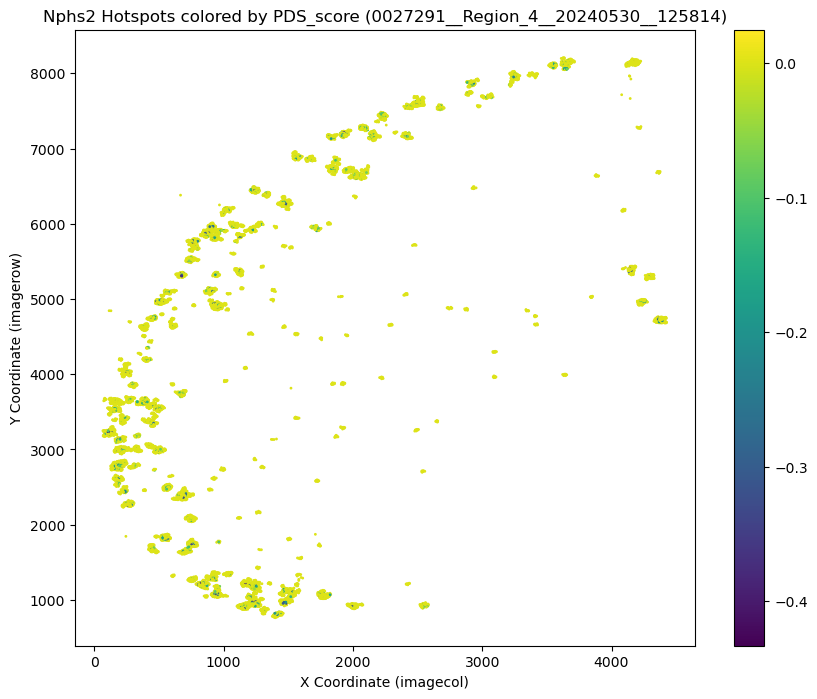

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


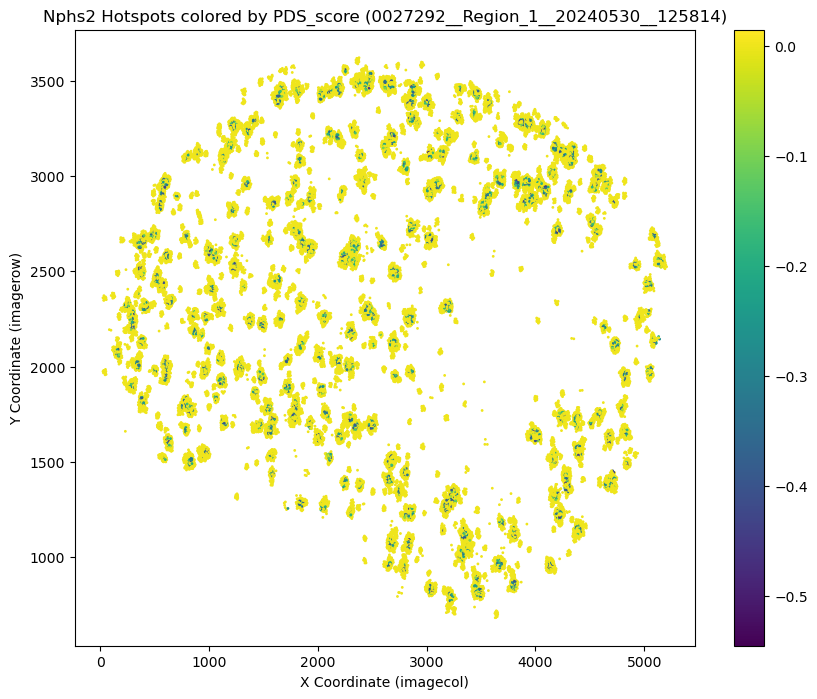

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


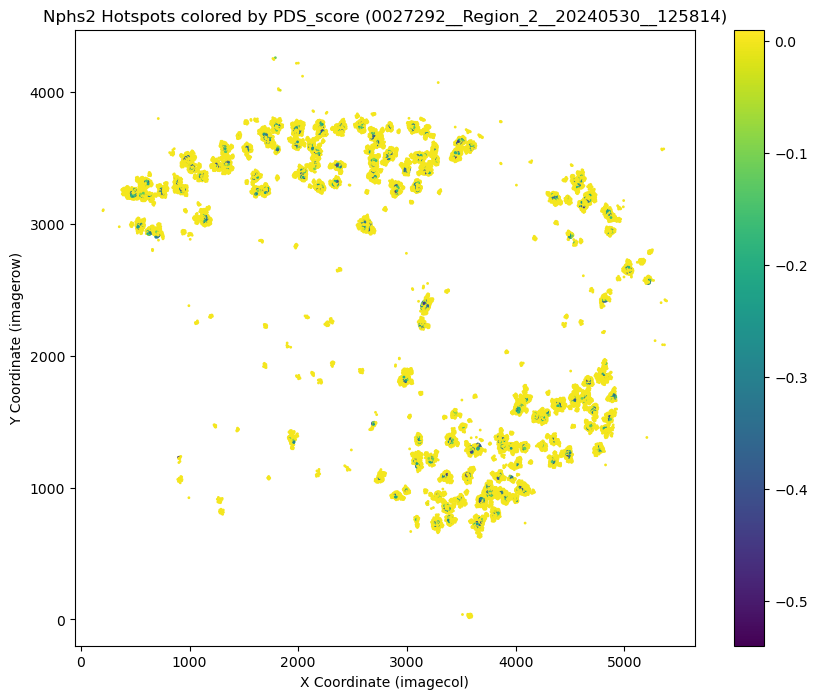

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


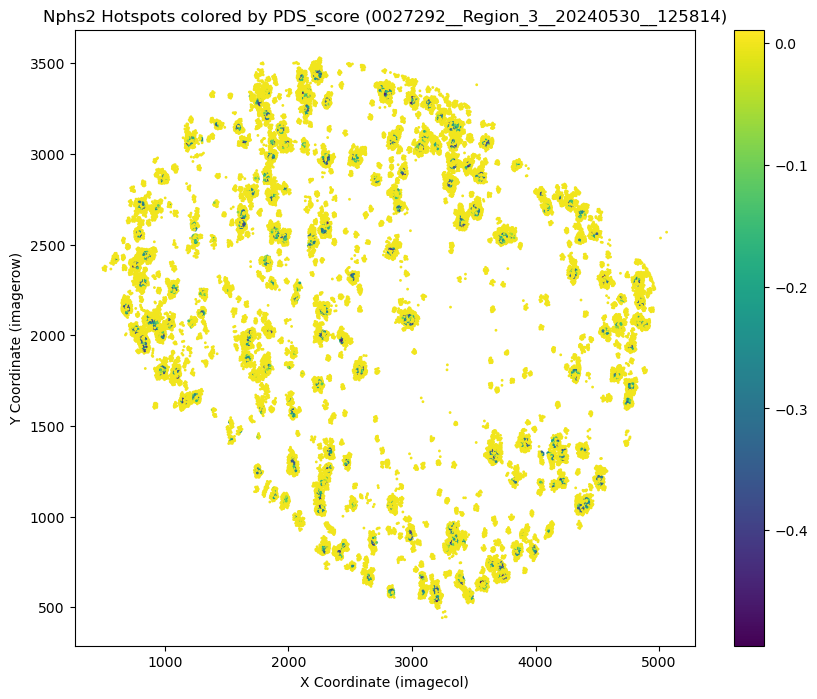

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


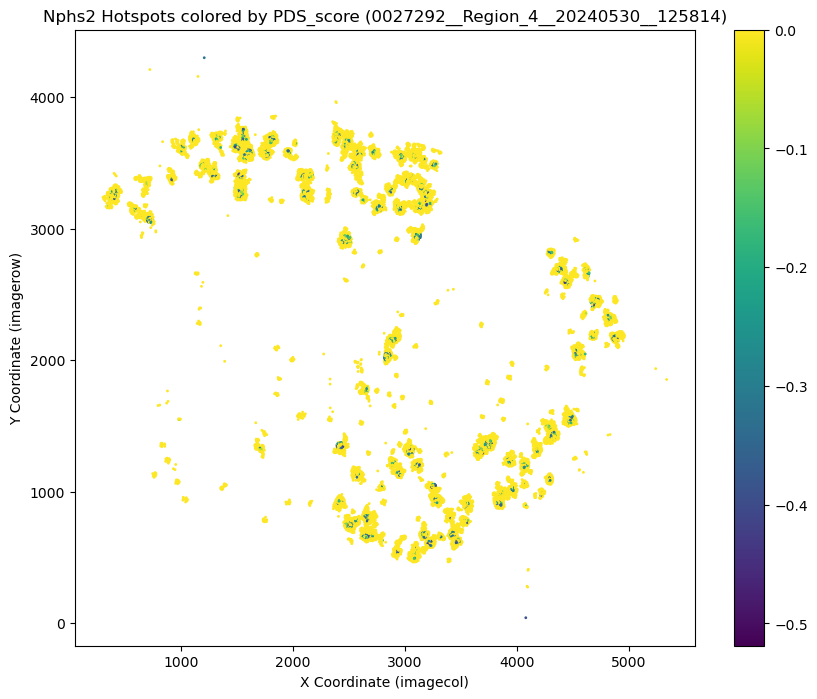

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


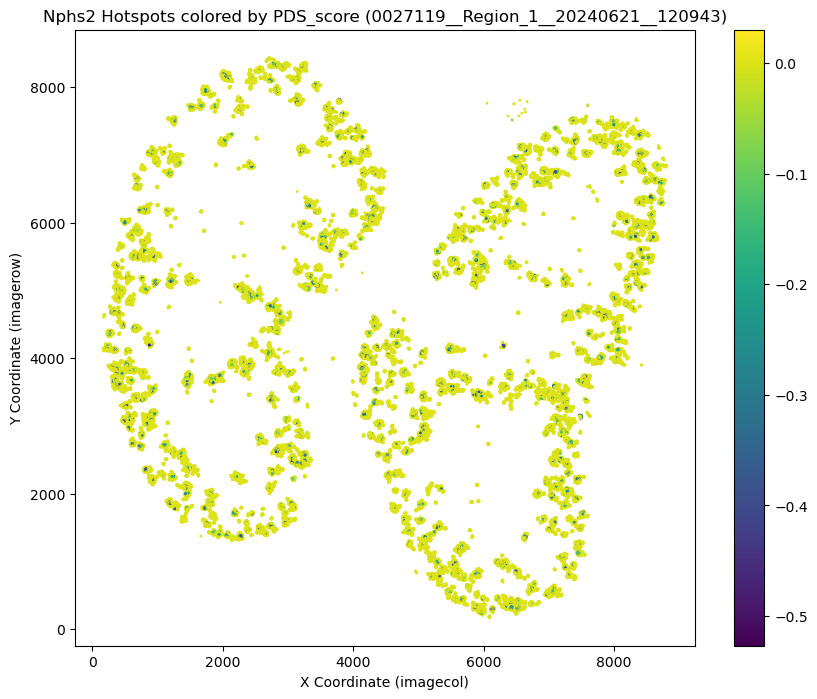

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


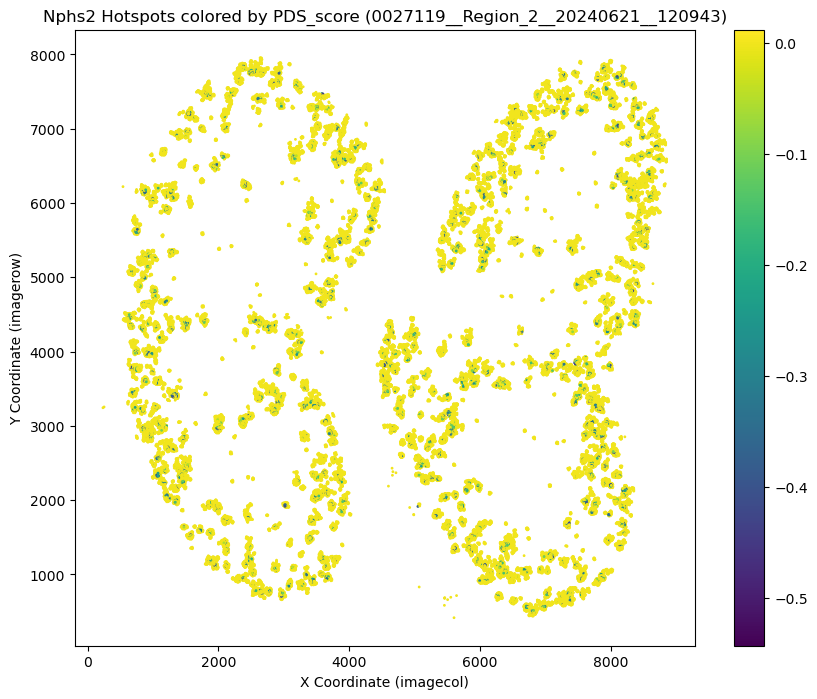

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


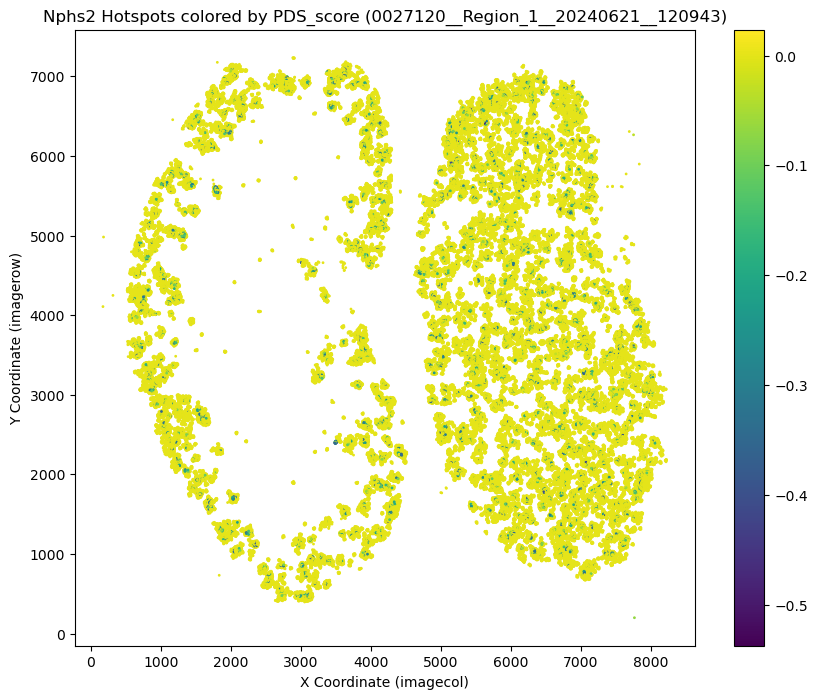

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


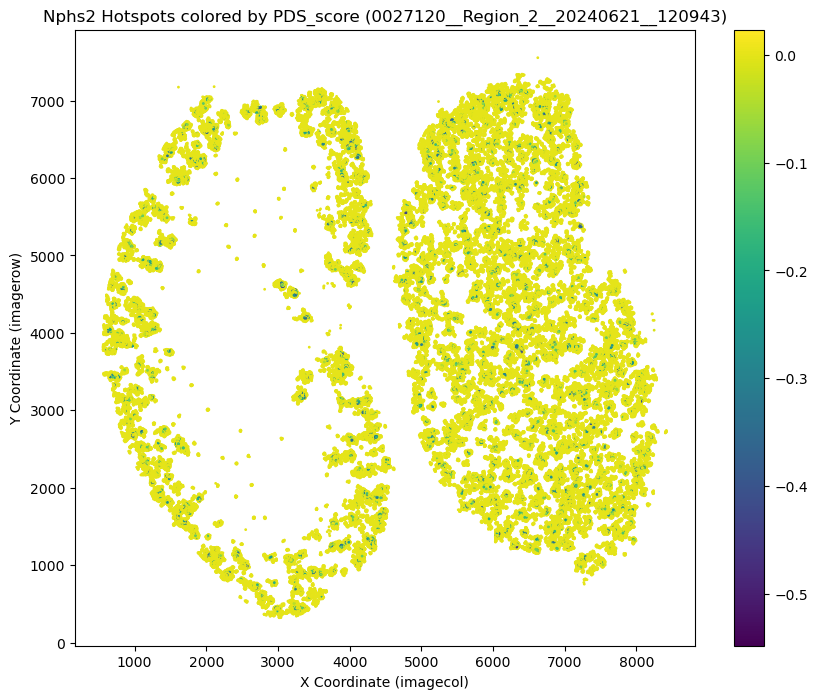

[INFO] (spatialdata_xenium_explorer.core.table) Writing 5 cell categories: sample, celltype_mapit, celltype_mapit_mean, celltype_dot, dbscan_cluster


In [10]:
task='MicroEnvChar'
target_feature='Nphs2'
k=11
eps=0.004 
min_samples=10
cluster_threshold=5
DSignature = pd.read_csv('/data/lemsaraa/amina/lncRNA/wt1os/DS_all.20.09.2023.tsv', sep='\t')
results_df = pd.DataFrame()
log_file = open(f"{out_folder}/{task}_verbose_mapit.log", "w")
sys.stdout = log_file  # Redirect print to the log file
print(f"""
            ## Configuration:
            Task = {task}
            target_feature = {target_feature}
            dbscan_eps = {eps}
            dbscan_min_samples = {min_samples}
            dbscan_cluster_threshold = {cluster_threshold}
            smoothing_k = {k}        
            """)

for DATASET, DATA_DIR in dataset_paths.items():
 
    print(f'Load dataset{DATASET}')
    # Load dataset
    path = f"{DATA_DIR}{DATASET}/"
    adata = st.ReadXenium(
        feature_cell_matrix_file=path + "cell_feature_matrix.h5",
        cell_summary_file=path + "cells.csv.gz"
    )
    adata.obs[target_feature] = adata[:, target_feature].X.toarray().flatten()
    adata.obs['sample'] = DATASET

    # Normalize data
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.obs[adata.var_names] = adata.X.toarray()

    # Load and integrate annotations
    annotation_path = f"{out_folder}/CellAnnotation_{DATASET}_mapit_all_celltype_l2.csv"
    annotation = pd.read_csv(annotation_path, index_col=0)
    adata.obs['celltype_mapit'] = 'NA'
    adata.obs.loc[annotation.index, 'celltype_mapit'] = annotation['predicted_annotation']
    
    annotation_path = f"{out_folder}/CellAnnotation_{DATASET}_mapit_mean_celltype_l2.csv"
    annotation = pd.read_csv(annotation_path, index_col=0)
    adata.obs['celltype_mapit_mean'] = 'NA'
    adata.obs.loc[annotation.index, 'celltype_mapit_mean'] = annotation['predicted_annotation']

    annotation_path = f"{out_folder}/CellAnnotation_{DATASET}_dot_celltype_l2.csv"
    annotation = pd.read_csv(annotation_path, index_col=0)
    adata.obs['celltype_dot'] = 'NA'
    adata.obs.loc[annotation.index, 'celltype_dot'] = annotation['predicted_annotation']

    print("1/ Compute PDS score")
    # Compute PDS score
    adata_sub = adata[adata.obs['celltype_mapit'].str.contains('Pod', na=False), :]
    expr_matrices = pd.DataFrame(
        data=adata_sub.X.toarray(),
        columns=adata_sub.var_names,
        index=adata_sub.obs_names
    )
    adata_sub.obs['PDS_score'] = ds_calc_func(expr_matrices.T,DSignature)
    adata.obs['PDS_score'] = 'NA'
    adata.obs.loc[adata_sub.obs_names, 'PDS_score'] = adata_sub.obs['PDS_score']

    
    print("1/ Compute PDS score mapit_mean")
    # Compute PDS score
    adata_sub = adata[adata.obs['celltype_mapit_mean'].str.contains('Pod', na=False), :]
    expr_matrices = pd.DataFrame(
        data=adata_sub.X.toarray(),
        columns=adata_sub.var_names,
        index=adata_sub.obs_names
    )
    adata_sub.obs['PDS_score_mapit_pseudo'] = ds_calc_func(expr_matrices.T,DSignature)
    adata.obs['PDS_score_mapit_pseudo'] = 'NA'
    adata.obs.loc[adata_sub.obs_names, 'PDS_score_mapit_pseudo'] = adata_sub.obs['PDS_score_mapit_pseudo']

    print("1/ Compute PDS score dot")
    # Compute PDS score
    adata_sub = adata[adata.obs['celltype_mapit_mean'].str.contains('Pod', na=False), :]
    expr_matrices = pd.DataFrame(
        data=adata_sub.X.toarray(),
        columns=adata_sub.var_names,
        index=adata_sub.obs_names
    )
    adata_sub.obs['PDS_score_dot'] = ds_calc_func(expr_matrices.T,DSignature)
    adata.obs['PDS_score_dot'] = 'NA'
    adata.obs.loc[adata_sub.obs_names, 'PDS_score_dot'] = adata_sub.obs['PDS_score_dot']
    
    del adata_sub  # Free memory
    print("2/ Run dbscan...")

    # Find Podocyte microenvironments and apply DBSCAN
    filtered_df = apply_dbscan_and_filter(adata.obs, k,target_feature,eps, min_samples, cluster_threshold)
    filtered_df['PDS_score'] = pd.to_numeric(filtered_df['PDS_score'], errors='coerce').fillna(0)
    # Visualization
    filtered_df['PDS_score'] = pd.to_numeric(filtered_df['PDS_score'], errors='coerce').fillna(0)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x=filtered_df['imagecol'],y=filtered_df['imagerow'],c=filtered_df['PDS_score'], cmap='viridis', s=1)
    plt.colorbar(scatter)    
    plt.xlabel('X Coordinate (imagecol)')
    plt.ylabel('Y Coordinate (imagerow)')
    plt.title(f'{target_feature} Hotspots colored by PDS_score ({DATASET})')
    plt.show()

    # Assign cluster labels back to adata
    adata.obs['dbscan_cluster'] = 'NA'
    adata.obs.loc[filtered_df.index, 'dbscan_cluster'] = filtered_df['cluster']
    adata.obs['dbscan_cluster'] = adata.obs['dbscan_cluster'].astype('category')
    spatialdata_xenium_explorer.write_cell_categories(DATA_DIR + DATASET, adata)
    # Collect results
    results_df = pd.concat([results_df, adata.obs], ignore_index=True)
print("\nEnded successfully.") 
sys.stdout = sys.__stdout__  # Reset to normal console output
log_file.close()


In [11]:
results_df.head()

,imagecol,imagerow,Nphs2,sample,0610005C13Rik,1110017D15Rik,2610528A11Rik,4921504A21Rik,5330417C22Rik,6330403K07Rik,...,Zfp36,tdtomato,celltype_mapit,celltype_mapit_mean,celltype_dot,PDS_score,PDS_score_mapit_pseudo,PDS_score_dot,Nphs2_aggregated,dbscan_cluster
0,350.618896,1178.920898,0.0,0027291__Region_1__20240530__125814,0.262627,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,PTS_Injured,PTS1,PTS_Injured,NA,NA,NA,0.000000,NA
1,397.014984,1180.800537,0.0,0027291__Region_1__20240530__125814,0.593912,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,PTS_Injured,PTS_Injured,PTS3,NA,NA,NA,0.000000,NA
2,361.421173,1169.710205,0.0,0027291__Region_1__20240530__125814,0.476924,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,PTS1,PTS1,Prol,NA,NA,NA,0.000000,NA
3,362.557251,1163.465820,0.0,0027291__Region_1__20240530__125814,0.874145,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,PTS1,PTS1,PTS1,NA,NA,NA,0.000000,NA
4,394.725647,1101.328613,0.0,0027291__Region_1__20240530__125814,0.610181,0.0,0.0,0.247059,0.0,0.0,...,0.445012,0.0,PTS1,PTS1,PTS1,NA,NA,NA,0.490476,0


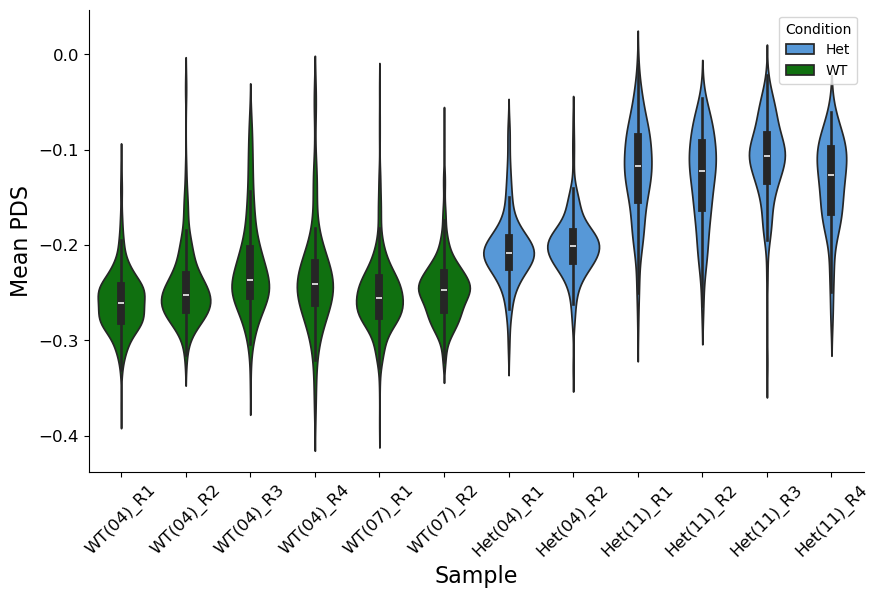

In [19]:
# Define the mapping of sample IDs to labels (genotype and age)
# sample_label_map = {
#     "0027292": ["WT","04"],   # WT (4)
#     "0027119": ["WT","07"],  # Het (7)
#     "0027120": ["Het","04"],   # Het (4)
#     "0027291": ["Het","11"]   # Het (11)
    
# }

# # Define a function to format sample labels
# def format_sample_label(sample_id):
#     # Split the sample_id into its components
#     parts = sample_id.split('__')
    
#     # Extract the genotype (first part of sample ID) and region (second part)
#     genotype = parts[0]
#     region = parts[1]
    
    
#     # Map genotype to label
#     genotype_label,age = sample_label_map[genotype]    
#     # Create formatted label: for example, "WT_R1(4)"
#     region_number = region.split('_')[1]  # Extract the region number (R1, R2, etc.)
#     formatted_label = f"{genotype_label}({age})_R{region_number}"
    
#     return formatted_label


# # Extract the substring before the first '__'
# results_df['sample_key'] = results_df['sample'].str.split('__').str[0]

# # Map the condition and age
# results_df['condition'] = results_df['sample_key'].map(lambda x: sample_label_map[x][0] if x in sample_label_map else None)
# results_df['age'] = results_df['sample_key'].map(lambda x: sample_label_map[x][1] if x in sample_label_map else None)
# results_df['sample_key'] = results_df["sample"].apply(format_sample_label)

# print(results_df)

# score='PDS_score'
# # Step 1: Filter the DataFrame
# filtered_df = results_df[(results_df['PDS_score'] != 'NA') & (results_df['dbscan_cluster'] != -1)]


# sample_order = sorted(filtered_df['sample_key'].unique(), key=lambda x: ('WT' not in x, x))

# # Step 5: Plot the violin plot, coloring by 'condition'
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=filtered_df, x='sample_key', y=score, hue='condition', order=sample_order, split=False)
# # plt.title(f'Violin Plot of {score} by Nphs2_NN, Sample, and Condition')
# plt.xlabel('Sample')
# plt.ylabel('PDS')
# plt.xticks(rotation=45)
# plt.legend(title='Condition')
# plt.show()


# # Step 2: Compute the mean PDS per Nphs2_NN and sample
# grouped_df = filtered_df.groupby(['dbscan_cluster', 'sample_key'])[score].mean().reset_index()

# # Step 3: Merge the condition information back to the grouped DataFrame
# # Assuming 'condition' is in the original DataFrame and you want to keep one value per group
# condition_df = filtered_df[['dbscan_cluster', 'sample_key', 'condition']].drop_duplicates()

# # Merge the condition data
# grouped_df = pd.merge(grouped_df, condition_df, on=['dbscan_cluster', 'sample_key'], how='left')

# Step 5: Plot the violin plot, coloring by 'condition'
plt.figure(figsize=(10, 6))
sns.violinplot(data=grouped_df, x='sample_key', y=score, hue='condition', order=sample_order, split=False, palette=('#4299EC','green'))
# plt.title(f'Violin Plot of Mean {score} by Nphs2_NN, Sample, and Condition')
sns.despine()
plt.xlabel('Sample',fontsize=16)
plt.ylabel('Mean PDS',fontsize=16)
plt.xticks(rotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Condition')
plt.show()


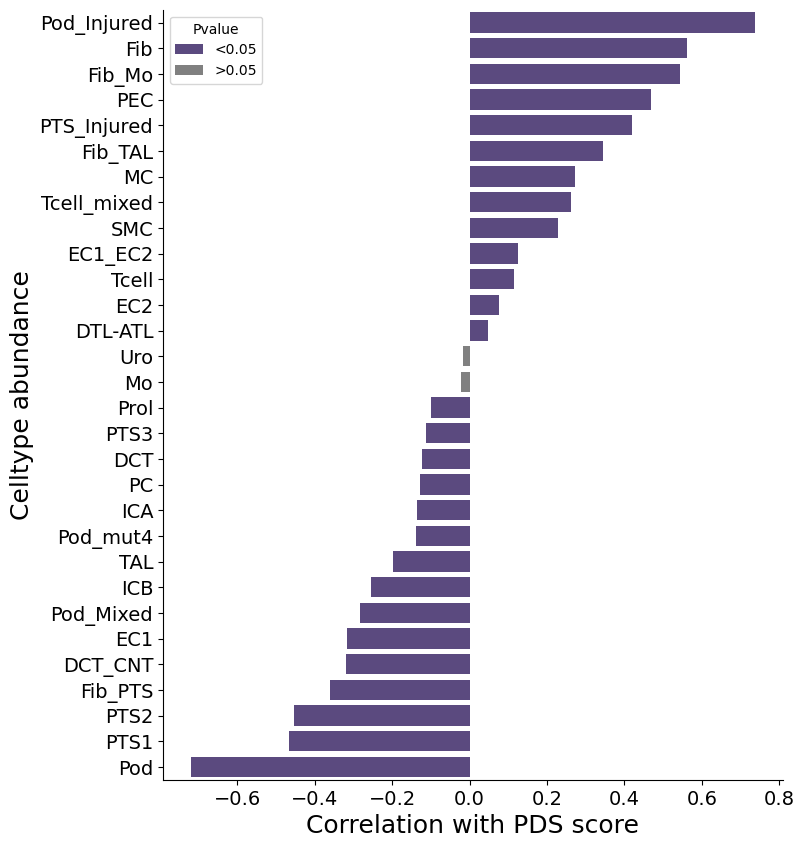

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

score='PDS_score'
cellt='celltype_mapit'
# Step 1: Filter the DataFrame
filtered_df = results_df[(results_df['dbscan_cluster'] != 'NA') &(results_df[cellt] != 'NA') &  (results_df['dbscan_cluster'] != -1)]

# Step 2: Calculate the percentage of each cell type within each Nphs2_NN and sample
# Group by Nphs2_NN, sample, and max_cellt_10 to calculate the count of each cell type
celltype_counts = filtered_df.groupby(['dbscan_cluster', 'sample', cellt]).size().reset_index(name='count')

# Step 3: Calculate the total count per Nphs2_NN and sample to get the percentage
total_counts = filtered_df.groupby(['dbscan_cluster', 'sample']).size().reset_index(name='total_count')
celltype_counts = pd.merge(celltype_counts, total_counts, on=['dbscan_cluster', 'sample'])

# Compute percentage of each cell type
celltype_counts['percentage'] = (celltype_counts['count'] / celltype_counts['total_count']) * 100

# Step 4: Merge the PDS data to calculate correlation
# Group by Nphs2_NN and sample to compute the mean PDS
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]

pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()

# Merge the celltype counts with the PDS means
merged_df = pd.merge(celltype_counts, pds_mean, on=['dbscan_cluster', 'sample'])

merged_df.dropna(subset=[score], inplace=True)  # Remove rows where 'PDS' is NaN

correlation_results = []

# Iterate over each unique cell type (max_cellt_10)
for celltype in merged_df[cellt].unique():
    # Filter data for the current celltype
    celltype_data = merged_df[merged_df[cellt] == celltype]
    
    # Check if there are at least 2 valid rows for correlation calculation
    if len(celltype_data) >= 2 and celltype_data['percentage'].notna().sum() > 1 and celltype_data[score].notna().sum() > 1:
        # Calculate the Pearson correlation and p-value between 'percentage' (celltype percentage) and 'PDS'
        corr, p_value = pearsonr(celltype_data['percentage'], celltype_data[score])
        # Store the result
        correlation_results.append({'celltype': celltype, 'correlation': corr, 'p_value': p_value})
    else:
        # If there are fewer than 2 valid data points, skip the correlation for this celltype
        correlation_results.append({'celltype': celltype, 'correlation': None, 'p_value': None})

# Convert the results into a DataFrame
correlation_df = pd.DataFrame(correlation_results)
# Display the results
print(correlation_df.loc[correlation_df.p_value<0.05,:])
# Filter out rows with NaN p_value
correlation_df_filtered = correlation_df.dropna(subset=['p_value'])

# Sort the DataFrame by p_value
correlation_df_filtered = correlation_df_filtered.sort_values(by='correlation',ascending=False)

# Create the 'significance' column based on p_value
correlation_df_filtered['Pvalue'] = correlation_df_filtered['p_value'].apply(lambda x: '<0.05' if x < 0.05 else '>0.05')

# Plot with the sorted data
plt.figure(figsize=(8, 10))

sns.barplot(data=correlation_df_filtered, y='celltype', x='correlation', hue='Pvalue', palette=('#584188','grey'))

# plt.title('Correlation between CellType abundance and PDS')
sns.despine()
plt.ylabel('Celltype abundance',fontsize=18)
plt.xlabel('Correlation with PDS score',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



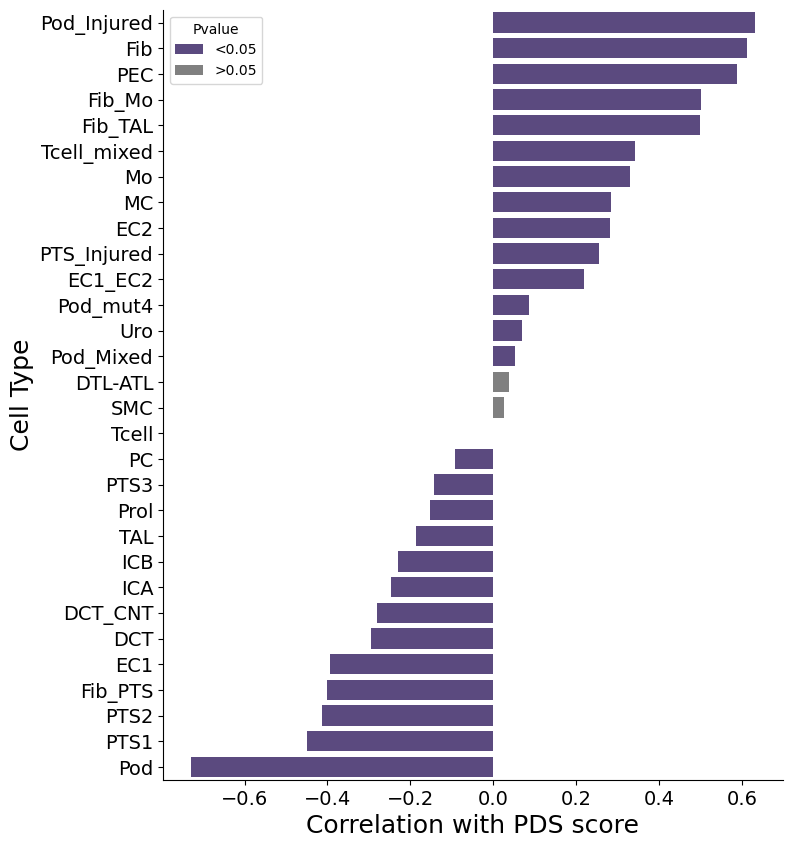

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

score='PDS_score'
cellt='celltype_dot'
# Step 1: Filter the DataFrame
filtered_df = results_df[(results_df['dbscan_cluster'] != 'NA') &(results_df[cellt] != 'NA') &  (results_df['dbscan_cluster'] != -1)]

# Step 2: Calculate the percentage of each cell type within each Nphs2_NN and sample
# Group by Nphs2_NN, sample, and max_cellt_10 to calculate the count of each cell type
celltype_counts = filtered_df.groupby(['dbscan_cluster', 'sample', cellt]).size().reset_index(name='count')

# Step 3: Calculate the total count per Nphs2_NN and sample to get the percentage
total_counts = filtered_df.groupby(['dbscan_cluster', 'sample']).size().reset_index(name='total_count')
celltype_counts = pd.merge(celltype_counts, total_counts, on=['dbscan_cluster', 'sample'])

# Compute percentage of each cell type
celltype_counts['percentage'] = (celltype_counts['count'] / celltype_counts['total_count']) * 100

# Step 4: Merge the PDS data to calculate correlation
# Group by Nphs2_NN and sample to compute the mean PDS
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]

pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()

# Merge the celltype counts with the PDS means
merged_df = pd.merge(celltype_counts, pds_mean, on=['dbscan_cluster', 'sample'])

merged_df.dropna(subset=[score], inplace=True)  # Remove rows where 'PDS' is NaN

correlation_results = []

# Iterate over each unique cell type (max_cellt_10)
for celltype in merged_df[cellt].unique():
    # Filter data for the current celltype
    celltype_data = merged_df[merged_df[cellt] == celltype]
    
    # Check if there are at least 2 valid rows for correlation calculation
    if len(celltype_data) >= 2 and celltype_data['percentage'].notna().sum() > 1 and celltype_data[score].notna().sum() > 1:
        # Calculate the Pearson correlation and p-value between 'percentage' (celltype percentage) and 'PDS'
        corr, p_value = pearsonr(celltype_data['percentage'], celltype_data[score])
        # Store the result
        correlation_results.append({'celltype': celltype, 'correlation': corr, 'p_value': p_value})
    else:
        # If there are fewer than 2 valid data points, skip the correlation for this celltype
        correlation_results.append({'celltype': celltype, 'correlation': None, 'p_value': None})

# Convert the results into a DataFrame
correlation_df = pd.DataFrame(correlation_results)
# Display the results
print(correlation_df.loc[correlation_df.p_value<0.05,:])
# Filter out rows with NaN p_value
correlation_df_filtered = correlation_df.dropna(subset=['p_value'])

# Sort the DataFrame by p_value
correlation_df_filtered = correlation_df_filtered.sort_values(by='correlation',ascending=False)

# Create the 'significance' column based on p_value
correlation_df_filtered['Pvalue'] = correlation_df_filtered['p_value'].apply(lambda x: '<0.05' if x < 0.05 else '>0.05')

# Plot with the sorted data
plt.figure(figsize=(8, 10))

sns.barplot(data=correlation_df_filtered, y='celltype', x='correlation', hue='Pvalue', palette=('#584188','grey'))

# plt.title('Correlation between CellType abundance and PDS')
sns.despine()
plt.ylabel('Cell Type',fontsize=18)
plt.xlabel('Correlation with PDS score',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



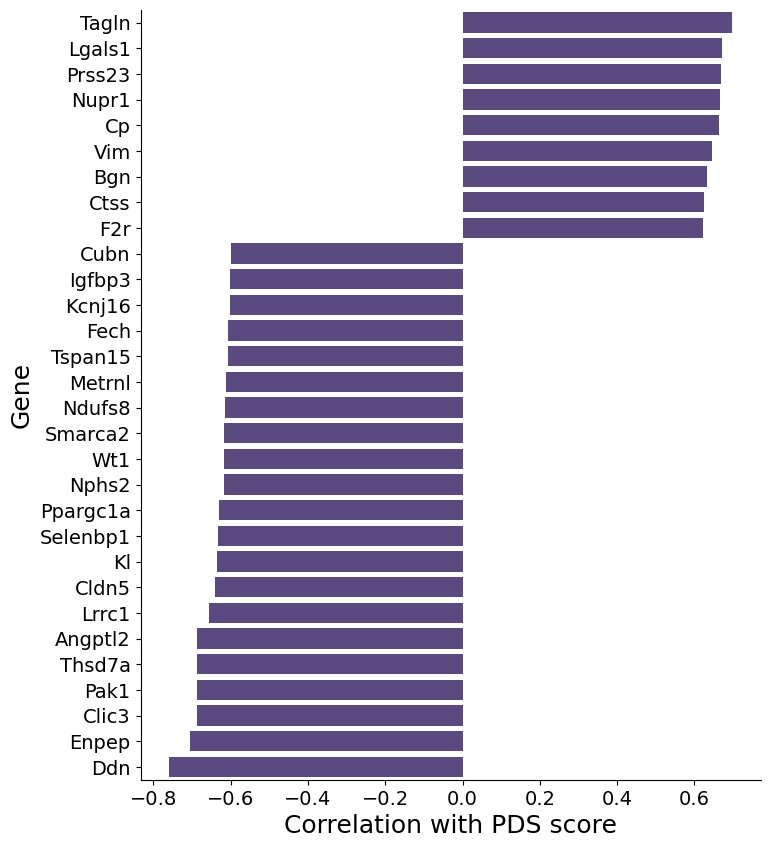

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

score='PDS_score'
filtered_df = results_df[(results_df['dbscan_cluster'] != 'NA') &  (results_df['dbscan_cluster'] != -1)]

var_mean = filtered_df.groupby(['dbscan_cluster', 'sample'])[adata.var_names].mean().reset_index()


# Step 4: Merge the PDS data to calculate correlation
# Group by Nphs2_NN and sample to compute the mean PDS
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]

pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()

# Merge the celltype counts with the PDS means
merged_df = pd.merge(var_mean, pds_mean, on=['dbscan_cluster', 'sample'])

merged_df.dropna(subset=[score], inplace=True)  # Remove rows where 'PDS' is NaN

correlation_results = []

for var in adata.var_names:
    if merged_df[var].sum() > 0:
        # Calculate the Pearson correlation and p-value between 'percentage' (celltype percentage) and 'PDS'
        corr, p_value = pearsonr(merged_df[var], merged_df[score])
        # Store the result
        correlation_results.append({'var': var, 'correlation': corr, 'p_value': p_value})
    else:
        # If there are fewer than 2 valid data points, skip the correlation for this celltype
        correlation_results.append({'var': var, 'correlation': None, 'p_value': None})

correlation_df = pd.DataFrame(correlation_results)
# print(correlation_df.loc[correlation_df.p_value<0.05,:])
correlation_df_filtered = correlation_df.dropna(subset=['p_value'])

correlation_df_filtered = correlation_df_filtered.sort_values(by='correlation',ascending=False)
correlation_df_filtered['Pvalue'] = correlation_df_filtered['p_value'].apply(lambda x: '<0.05' if x < 0.001 else '>0.05')

# # Plot with the sorted data
plt.figure(figsize=(8, 10))

sns.barplot(data=correlation_df_filtered[abs(correlation_df_filtered['correlation'])>0.6], y='var', x='correlation', palette=('#584188','#584188'))

# plt.title('Correlation between CellType abundance and PDS')
sns.despine()
plt.ylabel('Gene',fontsize=18)
plt.xlabel('Correlation with PDS score',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()



In [45]:
genes=correlation_df_filtered.loc[abs(correlation_df_filtered['correlation'])>0.6,'var']

In [42]:
genes.isin(DSignature

,gene_symbol,mean_rank,mean_rankSC,mean_rankBulk,direction_foldchange
0,Thsd7a,88.684783,84.464286,90.53125,-1
1,Aifm3,90.065217,118.357143,77.68750,-1
2,Metrnl,105.282609,94.428571,110.03125,-1
3,Nap1l1,108.195652,96.000000,113.53125,-1
4,Magi2,108.956522,64.142857,128.56250,-1
...,...,...,...,...,...
376,Dhx16,265.521739,266.071429,265.28125,-1
377,Ercc4,267.054348,284.607143,259.37500,-1
378,Spice1,268.076087,288.321429,259.21875,-1
379,Prpf6,273.847826,289.285714,267.09375,-1


In [17]:
correlation_df_filtered.to_csv(out_folder+'/correlation_df_GE_FU.csv')

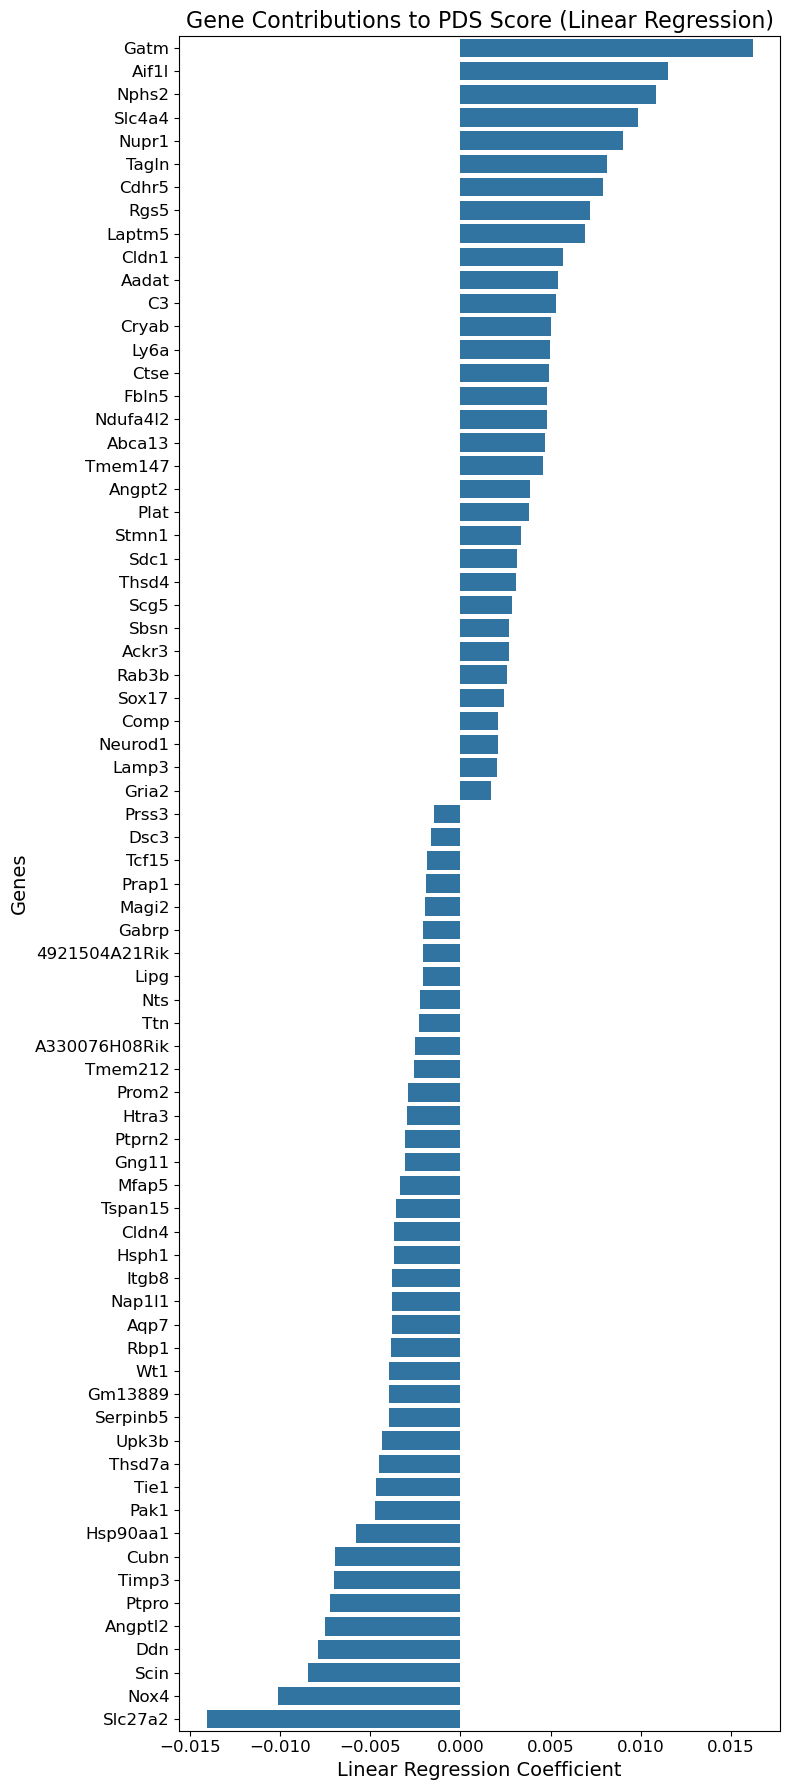

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np

# Assuming 'PDS_score' is already filtered in `filtered_df`
score = 'PDS_score'
filtered_df = results_df[(results_df['dbscan_cluster'] != 'NA') & (results_df['dbscan_cluster'] != -1)]

# Prepare mean gene expression data
var_mean = filtered_df.groupby(['dbscan_cluster', 'sample'])[adata.var_names].mean().reset_index()

# Merge with PDS score
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]
pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()
merged_df = pd.merge(var_mean, pds_mean, on=['dbscan_cluster', 'sample'])

# Drop rows with missing PDS_score or non-numeric values
merged_df.dropna(subset=[score], inplace=True)

# Ensure PDS_score is numeric
merged_df[score] = pd.to_numeric(merged_df[score], errors='coerce')

# Check that all genes are numeric
gene_columns = adata.var_names
merged_df[gene_columns] = merged_df[gene_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in gene expression
merged_df.dropna(inplace=True)

# Standardize the gene expression data
scaler = StandardScaler()
X = scaler.fit_transform(merged_df[gene_columns])  # Gene expression as predictors
y = merged_df[score]  # PDS_score as the target variable

# Fit linear regression using statsmodels
X_with_const = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X_with_const)  # Ordinary Least Squares (Linear Regression)
result = model.fit()

# Extract coefficients, p-values, and summary
coefficients = result.params[1:]  # Skip the intercept
p_values = result.pvalues[1:]     # Skip the intercept
genes = gene_columns

# Create a dataframe with results
linear_results_df = pd.DataFrame({
    'Gene': genes,
    'Coefficient': coefficients,
    'P_value': p_values
})

# Filter significant genes
linear_results_df['Significant'] = linear_results_df['P_value'] < 0.05
linear_results_df=linear_results_df[linear_results_df['Significant']]
# Sort by absolute value of coefficients
linear_results_df = linear_results_df.sort_values(by='Coefficient', ascending=False)

# Plot results
plt.figure(figsize=(8, 18))
sns.barplot(data=linear_results_df, 
            x='Coefficient', 
            y='Gene')

plt.title('Gene Contributions to PDS Score (Linear Regression)', fontsize=16)
plt.xlabel('Linear Regression Coefficient', fontsize=14)
plt.ylabel('Genes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [ ]:
task='MicroEnvChar_mapit_mean'
target_feature='Nphs2'
k=11
eps=0.004 
min_samples=10
cluster_threshold=5
DSignature = pd.read_csv('/data/lemsaraa/amina/lncRNA/wt1os/DS_all.20.09.2023.tsv', sep='\t')
results_df_matchit_mean = pd.DataFrame()
log_file = open(f"{out_folder}/{task}_verbose_mapit.log", "w")
sys.stdout = log_file  # Redirect print to the log file
print(f"""
            ## Configuration:
            Task = {task}
            target_feature = {target_feature}
            dbscan_eps = {eps}
            dbscan_min_samples = {min_samples}
            dbscan_cluster_threshold = {cluster_threshold}
            smoothing_k = {k}        
            """)

for DATASET, DATA_DIR in dataset_paths.items():
 
    print(f'Load dataset{DATASET}')
    # Load dataset
    path = f"{DATA_DIR}{DATASET}/"
    adata = st.ReadXenium(
        feature_cell_matrix_file=path + "cell_feature_matrix.h5",
        cell_summary_file=path + "cells.csv.gz"
    )
    adata.obs[target_feature] = adata[:, target_feature].X.toarray().flatten()
    adata.obs['sample'] = DATASET

    # Normalize data
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    # Load and integrate annotations
    annotation_path = f"{out_folder}/CellAnnotation_{DATASET}_mapit_mean_celltype_l2.csv"
    annotation = pd.read_csv(annotation_path, index_col=0)
    adata.obs['celltype'] = 'NA'
    adata.obs.loc[annotation.index, 'celltype'] = annotation['predicted_annotation']
    print("1/ Compute PDS score")
    # Compute PDS score
    adata_sub = adata[adata.obs['celltype'].str.contains('Pod', na=False), :]
    expr_matrices = pd.DataFrame(
        data=adata_sub.X.toarray(),
        columns=adata_sub.var_names,
        index=adata_sub.obs_names
    )
    adata_sub.obs['PDS_score'] = ds_calc_func(expr_matrices.T,DSignature)
    adata.obs['PDS_score'] = 'NA'
    adata.obs.loc[adata_sub.obs_names, 'PDS_score'] = adata_sub.obs['PDS_score']

    del adata_sub  # Free memory
    print("2/ Run dbscan...")

    # Find Podocyte microenvironments and apply DBSCAN
    filtered_df = apply_dbscan_and_filter(adata.obs, k,target_feature,eps, min_samples, cluster_threshold)
    filtered_df['PDS_score'] = pd.to_numeric(filtered_df['PDS_score'], errors='coerce').fillna(0)
    # Visualization
    filtered_df['PDS_score'] = pd.to_numeric(filtered_df['PDS_score'], errors='coerce').fillna(0)
    
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(x=filtered_df['imagecol'],y=filtered_df['imagerow'],c=filtered_df['PDS_score'], cmap='viridis', s=1)
#     plt.colorbar(scatter)    
#     plt.xlabel('X Coordinate (imagecol)')
#     plt.ylabel('Y Coordinate (imagerow)')
#     plt.title(f'{target_feature} Hotspots colored by PDS_score ({DATASET})')
#     plt.show()

    # Assign cluster labels back to adata
    adata.obs['dbscan_cluster'] = 'NA'
    adata.obs.loc[filtered_df.index, 'dbscan_cluster'] = filtered_df['cluster']
    adata.obs['dbscan_cluster'] = adata.obs['dbscan_cluster'].astype('category')
#     spatialdata_xenium_explorer.write_cell_categories(DATA_DIR + DATASET, adata)
    # Collect results
    results_df_matchit_mean = pd.concat([results_df_matchit_mean, adata.obs], ignore_index=True)
print("\nEnded successfully.") 
sys.stdout = sys.__stdout__  # Reset to normal console output
log_file.close()


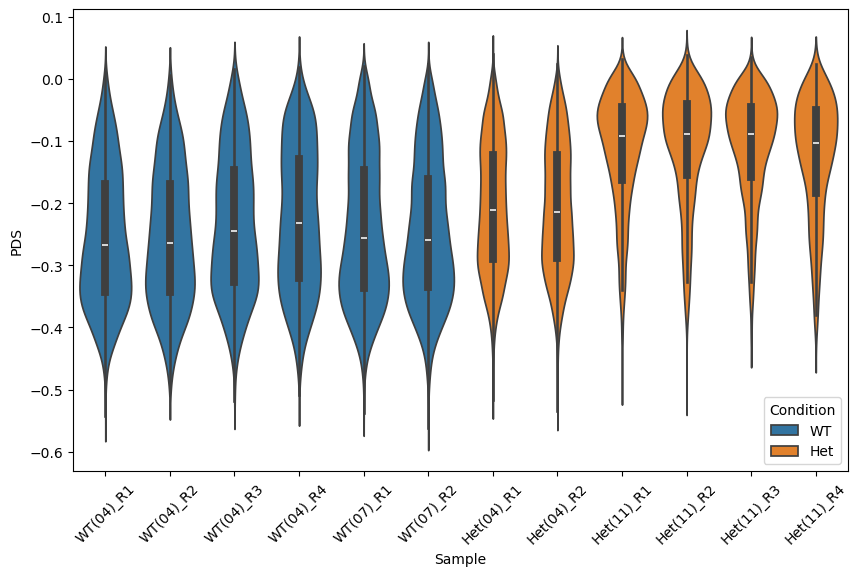

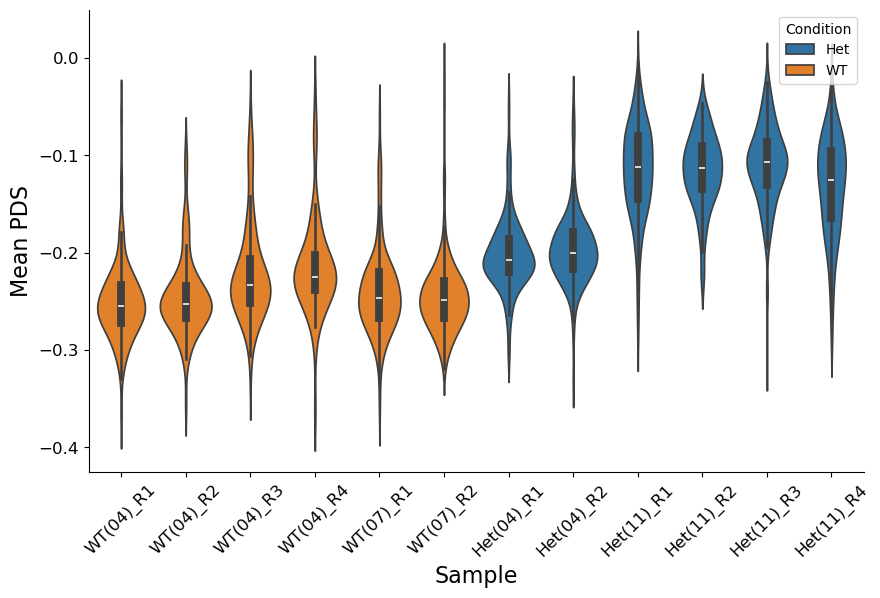

In [36]:
# Define the mapping of sample IDs to labels (genotype and age)
sample_label_map = {
    "0027292": ["WT","04"],   # WT (4)
    "0027119": ["WT","07"],  # Het (7)
    "0027120": ["Het","04"],   # Het (4)
    "0027291": ["Het","11"]   # Het (11)
    
}

# Define a function to format sample labels
def format_sample_label(sample_id):
    # Split the sample_id into its components
    parts = sample_id.split('__')
    
    # Extract the genotype (first part of sample ID) and region (second part)
    genotype = parts[0]
    region = parts[1]
    
    
    # Map genotype to label
    genotype_label,age = sample_label_map[genotype]    
    # Create formatted label: for example, "WT_R1(4)"
    region_number = region.split('_')[1]  # Extract the region number (R1, R2, etc.)
    formatted_label = f"{genotype_label}({age})_R{region_number}"
    
    return formatted_label


# Extract the substring before the first '__'
results_df_matchit_mean['sample_key'] = results_df_matchit_mean['sample'].str.split('__').str[0]

# Map the condition and age
results_df_matchit_mean['condition'] = results_df_matchit_mean['sample_key'].map(lambda x: sample_label_map[x][0] if x in sample_label_map else None)
results_df_matchit_mean['age'] = results_df_matchit_mean['sample_key'].map(lambda x: sample_label_map[x][1] if x in sample_label_map else None)
results_df_matchit_mean['sample_key'] = results_df_matchit_mean["sample"].apply(format_sample_label)


score='PDS_score'
# Step 1: Filter the DataFrame
filtered_df = results_df_matchit_mean[(results_df_matchit_mean['PDS_score'] != 'NA') & (results_df_matchit_mean['dbscan_cluster'] != -1)]


sample_order = sorted(filtered_df['sample_key'].unique(), key=lambda x: ('WT' not in x, x))

# Step 5: Plot the violin plot, coloring by 'condition'
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='sample_key', y=score, hue='condition', order=sample_order, split=False)
# plt.title(f'Violin Plot of {score} by Nphs2_NN, Sample, and Condition')
plt.xlabel('Sample')
plt.ylabel('PDS')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.show()


# Step 2: Compute the mean PDS per Nphs2_NN and sample
grouped_df = filtered_df.groupby(['dbscan_cluster', 'sample_key'])[score].mean().reset_index()

# Step 3: Merge the condition information back to the grouped DataFrame
# Assuming 'condition' is in the original DataFrame and you want to keep one value per group
condition_df = filtered_df[['dbscan_cluster', 'sample_key', 'condition']].drop_duplicates()

# Merge the condition data
grouped_df = pd.merge(grouped_df, condition_df, on=['dbscan_cluster', 'sample_key'], how='left')

# Step 5: Plot the violin plot, coloring by 'condition'
plt.figure(figsize=(10, 6))
sns.violinplot(data=grouped_df, x='sample_key', y=score, hue='condition', order=sample_order, split=False)
# plt.title(f'Violin Plot of Mean {score} by Nphs2_NN, Sample, and Condition')
sns.despine()
plt.xlabel('Sample',fontsize=16)
plt.ylabel('Mean PDS',fontsize=16)
plt.xticks(rotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Condition')
plt.show()


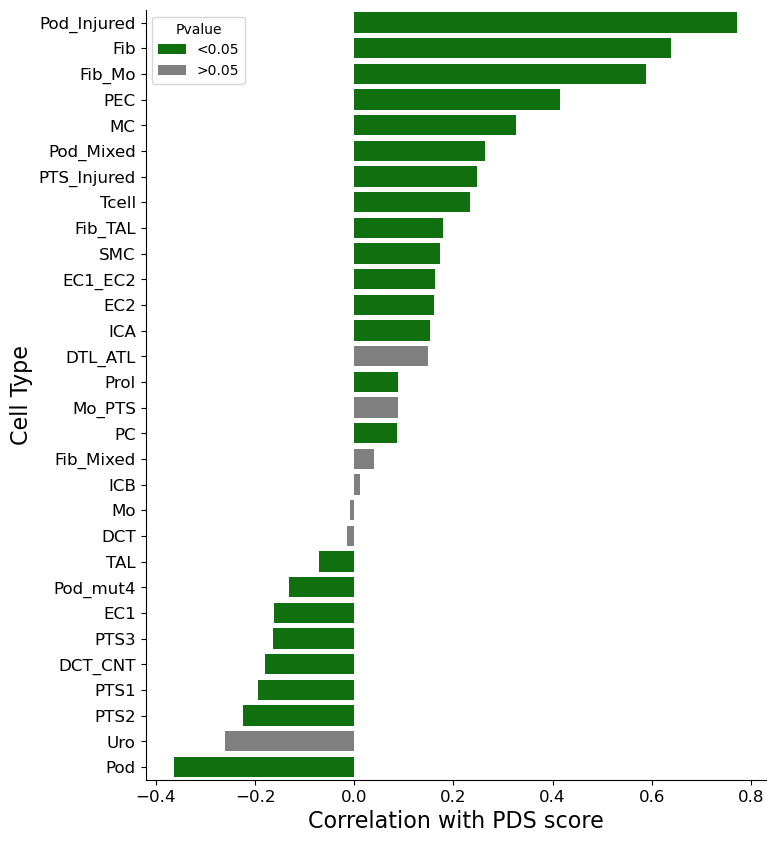

In [37]:
score='PDS_score'
cellt='celltype'
# Step 1: Filter the DataFrame
filtered_df = results_df_matchit_mean[(results_df_matchit_mean['dbscan_cluster'] != 'NA')  &(~results_df_matchit_mean[cellt].str.contains('nan', na=False)) &(results_df_matchit_mean[cellt] != 'NA') &  (results_df_matchit_mean['dbscan_cluster'] != -1)]

# Step 2: Calculate the percentage of each cell type within each Nphs2_NN and sample
# Group by Nphs2_NN, sample, and max_cellt_10 to calculate the count of each cell type
celltype_counts = filtered_df.groupby(['dbscan_cluster', 'sample', cellt]).size().reset_index(name='count')

# Step 3: Calculate the total count per Nphs2_NN and sample to get the percentage
total_counts = filtered_df.groupby(['dbscan_cluster', 'sample']).size().reset_index(name='total_count')
celltype_counts = pd.merge(celltype_counts, total_counts, on=['dbscan_cluster', 'sample'])

# Compute percentage of each cell type
celltype_counts['percentage'] = (celltype_counts['count'] / celltype_counts['total_count']) * 100

# Step 4: Merge the PDS data to calculate correlation
# Group by Nphs2_NN and sample to compute the mean PDS
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]

pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()

# Merge the celltype counts with the PDS means
merged_df = pd.merge(celltype_counts, pds_mean, on=['dbscan_cluster', 'sample'])

merged_df.dropna(subset=[score], inplace=True)  # Remove rows where 'PDS' is NaN

correlation_results = []

# Iterate over each unique cell type (max_cellt_10)
for celltype in merged_df[cellt].unique():
    # Filter data for the current celltype
    celltype_data = merged_df[merged_df[cellt] == celltype]
    
    # Check if there are at least 2 valid rows for correlation calculation
    if len(celltype_data) >= 2 and celltype_data['percentage'].notna().sum() > 1 and celltype_data[score].notna().sum() > 1:
        # Calculate the Pearson correlation and p-value between 'percentage' (celltype percentage) and 'PDS'
        corr, p_value = pearsonr(celltype_data['percentage'], celltype_data[score])
        # Store the result
        correlation_results.append({'celltype': celltype, 'correlation': corr, 'p_value': p_value})
    else:
        # If there are fewer than 2 valid data points, skip the correlation for this celltype
        correlation_results.append({'celltype': celltype, 'correlation': None, 'p_value': None})

# Convert the results into a DataFrame
correlation_df = pd.DataFrame(correlation_results)
# Display the results
print(correlation_df.loc[correlation_df.p_value<0.05,:])
# Filter out rows with NaN p_value
correlation_df_filtered = correlation_df.dropna(subset=['p_value'])

# Sort the DataFrame by p_value
correlation_df_filtered = correlation_df_filtered.sort_values(by='correlation',ascending=False)

# Create the 'significance' column based on p_value
correlation_df_filtered['Pvalue'] = correlation_df_filtered['p_value'].apply(lambda x: '<0.05' if x < 0.05 else '>0.05')

# Plot with the sorted data
plt.figure(figsize=(8, 10))

sns.barplot(data=correlation_df_filtered, y='celltype', x='correlation', hue='Pvalue', palette=('green','grey'))

# plt.title('Correlation between CellType abundance and PDS')
sns.despine()
plt.ylabel('Cell Type',fontsize=16)
plt.xlabel('Correlation with PDS score',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()



In [25]:
task='MicroEnvChar_dot'
target_feature='Nphs2'
k=11
eps=0.004 
min_samples=10
cluster_threshold=5
DSignature = pd.read_csv('/data/lemsaraa/amina/lncRNA/wt1os/DS_all.20.09.2023.tsv', sep='\t')
results_df_dot = pd.DataFrame()
log_file = open(f"{out_folder}/{task}_verbose_dot.log", "w")
sys.stdout = log_file  # Redirect print to the log file
print(f"""
            ## Configuration:
            Task = {task}
            target_feature = {target_feature}
            dbscan_eps = {eps}
            dbscan_min_samples = {min_samples}
            dbscan_cluster_threshold = {cluster_threshold}
            smoothing_k = {k}        
            """)

for DATASET, DATA_DIR in dataset_paths.items():
 
    print(f'Load dataset{DATASET}')
    # Load dataset
    path = f"{DATA_DIR}{DATASET}/"
    adata = st.ReadXenium(
        feature_cell_matrix_file=path + "cell_feature_matrix.h5",
        cell_summary_file=path + "cells.csv.gz"
    )
    adata.obs[target_feature] = adata[:, target_feature].X.toarray().flatten()
    adata.obs['sample'] = DATASET

    # Normalize data
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    # Load and integrate annotations
    annotation_path = f"{out_folder}/CellAnnotation_{DATASET}_dot_celltype_l2.csv"
    annotation = pd.read_csv(annotation_path, index_col=0)
    adata.obs['celltype'] = 'NA'
    adata.obs.loc[annotation.index, 'celltype'] = annotation['predicted_annotation']
    print("1/ Compute PDS score")
    # Compute PDS score
    adata_sub = adata[adata.obs['celltype'].str.contains('Pod', na=False), :]
    expr_matrices = pd.DataFrame(
        data=adata_sub.X.toarray(),
        columns=adata_sub.var_names,
        index=adata_sub.obs_names
    )
    adata_sub.obs['PDS_score'] = ds_calc_func(expr_matrices.T,DSignature)
    adata.obs['PDS_score'] = 'NA'
    adata.obs.loc[adata_sub.obs_names, 'PDS_score'] = adata_sub.obs['PDS_score']

    del adata_sub  # Free memory
    print("2/ Run dbscan...")

    # Find Podocyte microenvironments and apply DBSCAN
    filtered_df = apply_dbscan_and_filter(adata.obs, k,target_feature,eps, min_samples, cluster_threshold)
    filtered_df['PDS_score'] = pd.to_numeric(filtered_df['PDS_score'], errors='coerce').fillna(0)
    # Visualization
    filtered_df['PDS_score'] = pd.to_numeric(filtered_df['PDS_score'], errors='coerce').fillna(0)
    
#     plt.figure(figsize=(10, 8))
#     scatter = plt.scatter(x=filtered_df['imagecol'],y=filtered_df['imagerow'],c=filtered_df['PDS_score'], cmap='viridis', s=1)
#     plt.colorbar(scatter)    
#     plt.xlabel('X Coordinate (imagecol)')
#     plt.ylabel('Y Coordinate (imagerow)')
#     plt.title(f'{target_feature} Hotspots colored by PDS_score ({DATASET})')
#     plt.show()

    # Assign cluster labels back to adata
    adata.obs['dbscan_cluster'] = 'NA'
    adata.obs.loc[filtered_df.index, 'dbscan_cluster'] = filtered_df['cluster']
    adata.obs['dbscan_cluster'] = adata.obs['dbscan_cluster'].astype('category')
#     spatialdata_xenium_explorer.write_cell_categories(DATA_DIR + DATASET, adata)
    # Collect results
    results_df_dot = pd.concat([results_df_dot, adata.obs], ignore_index=True)
print("\nEnded successfully.") 
sys.stdout = sys.__stdout__  # Reset to normal console output
log_file.close()


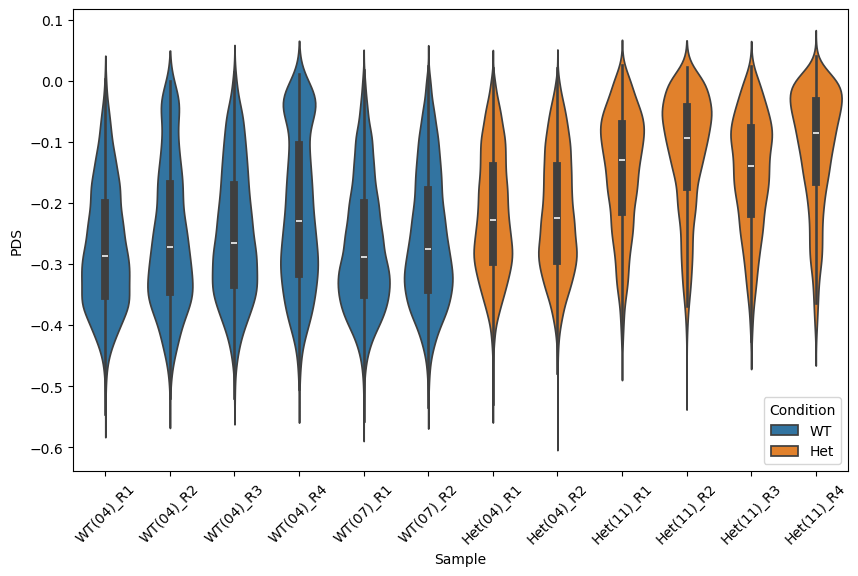

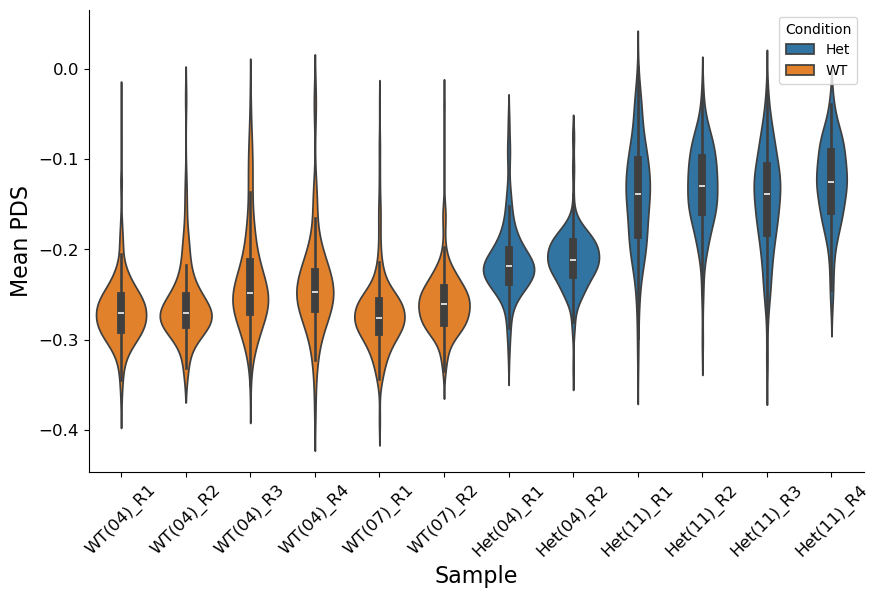

In [26]:
# Define the mapping of sample IDs to labels (genotype and age)
sample_label_map = {
    "0027292": ["WT","04"],   # WT (4)
    "0027119": ["WT","07"],  # Het (7)
    "0027120": ["Het","04"],   # Het (4)
    "0027291": ["Het","11"]   # Het (11)
    
}

# Define a function to format sample labels
def format_sample_label(sample_id):
    # Split the sample_id into its components
    parts = sample_id.split('__')
    
    # Extract the genotype (first part of sample ID) and region (second part)
    genotype = parts[0]
    region = parts[1]
    
    
    # Map genotype to label
    genotype_label,age = sample_label_map[genotype]    
    # Create formatted label: for example, "WT_R1(4)"
    region_number = region.split('_')[1]  # Extract the region number (R1, R2, etc.)
    formatted_label = f"{genotype_label}({age})_R{region_number}"
    
    return formatted_label


# Extract the substring before the first '__'
results_df_dot['sample_key'] = results_df_dot['sample'].str.split('__').str[0]

# Map the condition and age
results_df_dot['condition'] = results_df_dot['sample_key'].map(lambda x: sample_label_map[x][0] if x in sample_label_map else None)
results_df_dot['age'] = results_df_dot['sample_key'].map(lambda x: sample_label_map[x][1] if x in sample_label_map else None)
results_df_dot['sample_key'] = results_df_dot["sample"].apply(format_sample_label)


score='PDS_score'
# Step 1: Filter the DataFrame
filtered_df = results_df_dot[(results_df_dot['PDS_score'] != 'NA') & (results_df_dot['dbscan_cluster'] != -1)]


sample_order = sorted(filtered_df['sample_key'].unique(), key=lambda x: ('WT' not in x, x))

# Step 5: Plot the violin plot, coloring by 'condition'
plt.figure(figsize=(10, 6))
sns.violinplot(data=filtered_df, x='sample_key', y=score, hue='condition', order=sample_order, split=False)
# plt.title(f'Violin Plot of {score} by Nphs2_NN, Sample, and Condition')
plt.xlabel('Sample')
plt.ylabel('PDS')
plt.xticks(rotation=45)
plt.legend(title='Condition')
plt.show()


# Step 2: Compute the mean PDS per Nphs2_NN and sample
grouped_df = filtered_df.groupby(['dbscan_cluster', 'sample_key'])[score].mean().reset_index()

# Step 3: Merge the condition information back to the grouped DataFrame
# Assuming 'condition' is in the original DataFrame and you want to keep one value per group
condition_df = filtered_df[['dbscan_cluster', 'sample_key', 'condition']].drop_duplicates()

# Merge the condition data
grouped_df = pd.merge(grouped_df, condition_df, on=['dbscan_cluster', 'sample_key'], how='left')

# Step 5: Plot the violin plot, coloring by 'condition'
plt.figure(figsize=(10, 6))
sns.violinplot(data=grouped_df, x='sample_key', y=score, hue='condition', order=sample_order, split=False)
# plt.title(f'Violin Plot of Mean {score} by Nphs2_NN, Sample, and Condition')
sns.despine()
plt.xlabel('Sample',fontsize=16)
plt.ylabel('Mean PDS',fontsize=16)
plt.xticks(rotation=45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Condition')
plt.show()


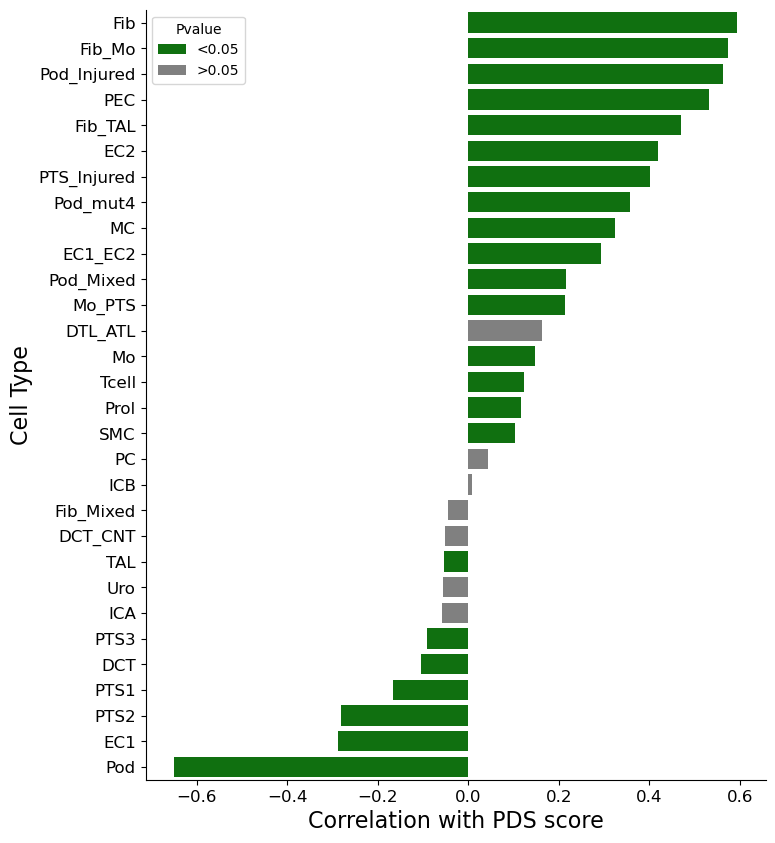

In [27]:
score='PDS_score'
cellt='celltype'
# Step 1: Filter the DataFrame
filtered_df = results_df_dot[(results_df_dot['dbscan_cluster'] != 'NA')  &(~results_df_dot[cellt].str.contains('nan', na=False)) &(results_df_dot[cellt] != 'NA') &  (results_df_dot['dbscan_cluster'] != -1)]

# Step 2: Calculate the percentage of each cell type within each Nphs2_NN and sample
# Group by Nphs2_NN, sample, and max_cellt_10 to calculate the count of each cell type
celltype_counts = filtered_df.groupby(['dbscan_cluster', 'sample', cellt]).size().reset_index(name='count')

# Step 3: Calculate the total count per Nphs2_NN and sample to get the percentage
total_counts = filtered_df.groupby(['dbscan_cluster', 'sample']).size().reset_index(name='total_count')
celltype_counts = pd.merge(celltype_counts, total_counts, on=['dbscan_cluster', 'sample'])

# Compute percentage of each cell type
celltype_counts['percentage'] = (celltype_counts['count'] / celltype_counts['total_count']) * 100

# Step 4: Merge the PDS data to calculate correlation
# Group by Nphs2_NN and sample to compute the mean PDS
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]

pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()

# Merge the celltype counts with the PDS means
merged_df = pd.merge(celltype_counts, pds_mean, on=['dbscan_cluster', 'sample'])

merged_df.dropna(subset=[score], inplace=True)  # Remove rows where 'PDS' is NaN

correlation_results = []

# Iterate over each unique cell type (max_cellt_10)
for celltype in merged_df[cellt].unique():
    # Filter data for the current celltype
    celltype_data = merged_df[merged_df[cellt] == celltype]
    
    # Check if there are at least 2 valid rows for correlation calculation
    if len(celltype_data) >= 2 and celltype_data['percentage'].notna().sum() > 1 and celltype_data[score].notna().sum() > 1:
        # Calculate the Pearson correlation and p-value between 'percentage' (celltype percentage) and 'PDS'
        corr, p_value = pearsonr(celltype_data['percentage'], celltype_data[score])
        # Store the result
        correlation_results.append({'celltype': celltype, 'correlation': corr, 'p_value': p_value})
    else:
        # If there are fewer than 2 valid data points, skip the correlation for this celltype
        correlation_results.append({'celltype': celltype, 'correlation': None, 'p_value': None})

# Convert the results into a DataFrame
correlation_df = pd.DataFrame(correlation_results)
# Display the results
print(correlation_df.loc[correlation_df.p_value<0.05,:])
# Filter out rows with NaN p_value
correlation_df_filtered = correlation_df.dropna(subset=['p_value'])

# Sort the DataFrame by p_value
correlation_df_filtered = correlation_df_filtered.sort_values(by='correlation',ascending=False)

# Create the 'significance' column based on p_value
correlation_df_filtered['Pvalue'] = correlation_df_filtered['p_value'].apply(lambda x: '<0.05' if x < 0.05 else '>0.05')

# Plot with the sorted data
plt.figure(figsize=(8, 10))

sns.barplot(data=correlation_df_filtered, y='celltype', x='correlation', hue='Pvalue', palette=('green','grey'))

# plt.title('Correlation between CellType abundance and PDS')
sns.despine()
plt.ylabel('Cell Type',fontsize=16)
plt.xlabel('Correlation with PDS score',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np

# Assuming 'PDS_score' is already filtered in `filtered_df`
score = 'PDS_score'
filtered_df = results_df_dot[(results_df_dot['dbscan_cluster'] != 'NA') & (results_df_dot['dbscan_cluster'] != -1)]

# Prepare mean gene expression data
var_mean = filtered_df.groupby(['dbscan_cluster', 'sample'])[adata.var_names].mean().reset_index()

# Merge with PDS score
filtered_df_ = filtered_df[(filtered_df[score] != 'NA')]
pds_mean = filtered_df_.groupby(['dbscan_cluster', 'sample'])[score].mean().reset_index()
merged_df = pd.merge(var_mean, pds_mean, on=['dbscan_cluster', 'sample'])

# Drop rows with missing PDS_score or non-numeric values
merged_df.dropna(subset=[score], inplace=True)

# Ensure PDS_score is numeric
merged_df[score] = pd.to_numeric(merged_df[score], errors='coerce')

# Check that all genes are numeric
gene_columns = adata.var_names
merged_df[gene_columns] = merged_df[gene_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values in gene expression
merged_df.dropna(inplace=True)

# Standardize the gene expression data
scaler = StandardScaler()
X = scaler.fit_transform(merged_df[gene_columns])  # Gene expression as predictors
y = merged_df[score]  # PDS_score as the target variable

# Fit linear regression using statsmodels
X_with_const = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X_with_const)  # Ordinary Least Squares (Linear Regression)
result = model.fit()

# Extract coefficients, p-values, and summary
coefficients = result.params[1:]  # Skip the intercept
p_values = result.pvalues[1:]     # Skip the intercept
genes = gene_columns

# Create a dataframe with results
linear_results_df = pd.DataFrame({
    'Gene': genes,
    'Coefficient': coefficients,
    'P_value': p_values
})

# Filter significant genes
linear_results_df['Significant'] = linear_results_df['P_value'] < 0.05
linear_results_df=linear_results_df[linear_results_df['Significant']]
# Sort by absolute value of coefficients
linear_results_df = linear_results_df.sort_values(by='Coefficient', ascending=False)

# Plot results
plt.figure(figsize=(8, 18))
sns.barplot(data=linear_results_df, 
            x='Coefficient', 
            y='Gene')

plt.title('Gene Contributions to PDS Score (Linear Regression)', fontsize=16)
plt.xlabel('Linear Regression Coefficient', fontsize=14)
plt.ylabel('Genes', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

